In [2]:
import pandas as pd

# Load the data
file_path = "/content/ai_dev_assignment_tickets_complex_1000.xls"
df = pd.read_excel(file_path)

# Basic info
print("Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())

# Peek at data
df.head()


Shape: (1000, 5)

Missing Values:
 ticket_id         0
ticket_text      55
issue_type       76
urgency_level    52
product           0
dtype: int64


,ticket_id,ticket_text,issue_type,urgency_level,product
0,1,Payment issue for my SmartWatch V2. I was unde...,Billing Problem,Medium,SmartWatch V2
1,2,Can you tell me more about the UltraClean Vacu...,General Inquiry,NaN,UltraClean Vacuum
2,3,I ordered SoundWave 300 but got EcoBreeze AC i...,Wrong Item,Medium,SoundWave 300
3,4,Facing installation issue with PhotoSnap Cam. ...,Installation Issue,Low,PhotoSnap Cam
4,5,Order #30903 for Vision LED TV is 13 days late...,Late Delivery,NaN,Vision LED TV


In [3]:
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob


nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove special characters & numbers (keep words and dates)
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Add this line to download the missing resource

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove special characters and numbers except dates
    text = re.sub(r"[^a-z\s]", "", text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

# Apply preprocessing
df['clean_text'] = df['ticket_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [15]:
print(df['ticket_text'].isnull().sum())

55


In [16]:
df['ticket_text'] = df['ticket_text'].fillna('')  # Replace missing with empty string


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# Text features
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Custom features: ticket length & sentiment
df['ticket_length'] = df['ticket_text'].apply(lambda x: len(str(x)))
df['sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Combine all features
import scipy
X_custom = df[['ticket_length', 'sentiment']].values
X_full = scipy.sparse.hstack((X_tfidf, X_custom))


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Clean missing text
df['ticket_text'] = df['ticket_text'].fillna('')

# Vectorize again
vectorizer = TfidfVectorizer()
X_full = vectorizer.fit_transform(df['ticket_text'])


In [18]:
y_issue = df['issue_type'].fillna('Unknown')
y_urgency = df['urgency_level'].fillna('Medium')


In [22]:
# 1. Drop rows with missing labels
df = df.dropna(subset=['issue_type', 'urgency_level'])

# 2. Reset index (optional but clean)
df = df.reset_index(drop=True)

# 3. Fix ticket_text just to be safe
df['ticket_text'] = df['ticket_text'].fillna('')

# 4. Rebuild features
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_full = vectorizer.fit_transform(df['ticket_text'])

# 5. Redefine targets
y_issue = df['issue_type']
y_urgency = df['urgency_level']


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# 1. Clean missing data
df = df.dropna(subset=['ticket_text', 'issue_type', 'urgency_level']).reset_index(drop=True)
df['ticket_text'] = df['ticket_text'].fillna('')

# 2. Feature extraction: TF-IDF
vectorizer = TfidfVectorizer()
X_full = vectorizer.fit_transform(df['ticket_text'])

# 3. Labels
y_issue = df['issue_type']
y_urgency = df['urgency_level']

# 4. Train-test split
X_train, X_test, y_train_issue, y_test_issue = train_test_split(X_full, y_issue, test_size=0.2, random_state=42)
_, _, y_train_urgency, y_test_urgency = train_test_split(X_full, y_urgency, test_size=0.2, random_state=42)

# 5. Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel='linear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB()
}

# 6. Evaluate models for Issue Type
print("🔹 Issue Type Classification\n")
best_issue_model = None
best_issue_acc = 0

for name, model in models.items():
    model.fit(X_train, y_train_issue)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test_issue, pred)

    print(f"🔸 {name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test_issue, pred))

    if acc > best_issue_acc:
        best_issue_acc = acc
        best_issue_model = model

# 7. Evaluate models for Urgency Level
print("\n🔹 Urgency Level Classification\n")
best_urgency_model = None
best_urgency_acc = 0

for name, model in models.items():
    model.fit(X_train, y_train_urgency)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test_urgency, pred)

    print(f"🔸 {name} - Accuracy: {acc:.4f}")
    print(classification_report(y_test_urgency, pred))

    if acc > best_urgency_acc:
        best_urgency_acc = acc
        best_urgency_model = model

# 8. Output final best models
print("\n✅ Best Models:")
print(f"🔹 Issue Type: {type(best_issue_model).__name__} (Accuracy: {best_issue_acc:.4f})")
print(f"🔹 Urgency Level: {type(best_urgency_model).__name__} (Accuracy: {best_urgency_acc:.4f})")


🔹 Issue Type Classification

🔸 Logistic Regression - Accuracy: 0.9432
                    precision    recall  f1-score   support

    Account Access       1.00      0.97      0.99        35
   Billing Problem       1.00      0.91      0.95        32
   General Inquiry       1.00      0.93      0.96        29
Installation Issue       1.00      0.92      0.96        24
     Late Delivery       0.67      1.00      0.80        20
    Product Defect       1.00      0.95      0.97        19
        Wrong Item       1.00      0.94      0.97        17

          accuracy                           0.94       176
         macro avg       0.95      0.94      0.94       176
      weighted avg       0.96      0.94      0.95       176

🔸 SVM - Accuracy: 0.9432
                    precision    recall  f1-score   support

    Account Access       1.00      0.97      0.99        35
   Billing Problem       1.00      0.91      0.95        32
   General Inquiry       1.00      0.93      0.96        29
I

In [25]:
print(df['urgency_level'].value_counts())


urgency_level
High      303
Medium    297
Low       276
Name: count, dtype: int64


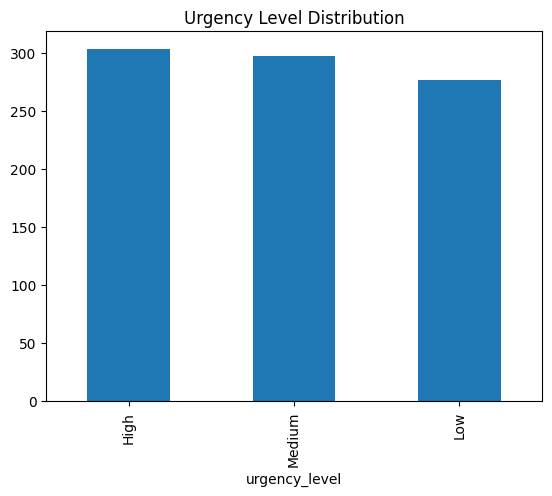

In [26]:
import matplotlib.pyplot as plt

df['urgency_level'].value_counts().plot(kind='bar')
plt.title('Urgency Level Distribution')
plt.show()


In [27]:
from textblob import TextBlob
import numpy as np

# Ticket length (word count)
df['ticket_length'] = df['ticket_text'].apply(lambda x: len(x.split()))

# Sentiment polarity (from -1 to 1)
df['sentiment'] = df['ticket_text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Urgency keywords presence (1 if any keyword is found, else 0)
urgency_keywords = ['urgent', 'immediately', 'asap', 'help', 'as soon as possible', 'now', 'quickly']

def has_urgency_keyword(text):
    text_lower = text.lower()
    return int(any(keyword in text_lower for keyword in urgency_keywords))

df['urgency_keyword'] = df['ticket_text'].apply(has_urgency_keyword)


In [28]:
from scipy.sparse import hstack

# Select extra features as numpy array
extra_features = df[['ticket_length', 'sentiment', 'urgency_keyword']].values

# Combine sparse TF-IDF matrix with dense extra features
X_full_enhanced = hstack([X_full, extra_features])


In [29]:
X_train, X_test, y_train_urgency, y_test_urgency = train_test_split(
    X_full_enhanced, y_urgency, test_size=0.2, random_state=42)


In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train_urgency)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test_urgency, pred)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test_urgency, pred))


Logistic Regression Accuracy: 0.3523
              precision    recall  f1-score   support

        High       0.37      0.42      0.39        60
         Low       0.32      0.30      0.31        54
      Medium       0.36      0.34      0.35        62

    accuracy                           0.35       176
   macro avg       0.35      0.35      0.35       176
weighted avg       0.35      0.35      0.35       176

Random Forest Accuracy: 0.3239
              precision    recall  f1-score   support

        High       0.36      0.35      0.35        60
         Low       0.25      0.26      0.26        54
      Medium       0.35      0.35      0.35        62

    accuracy                           0.32       176
   macro avg       0.32      0.32      0.32       176
weighted avg       0.32      0.32      0.32       176



In [31]:
!pip install -q sentence-transformers

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer

# 1. Prepare data (drop missing labels, fill text)
df = df.dropna(subset=['ticket_text', 'urgency_level']).reset_index(drop=True)
df['ticket_text'] = df['ticket_text'].fillna('')

# 2. Load pre-trained SentenceTransformer model
model_name = 'all-MiniLM-L6-v2'  # lightweight, good performance
embedder = SentenceTransformer(model_name)

# 3. Encode ticket texts into embeddings (this takes some seconds)
embeddings = embedder.encode(df['ticket_text'].tolist())

# 4. Split data
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df['urgency_level'], test_size=0.2, random_state=42)

# 5. Train classical classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, preds))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.8 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Logistic Regression Accuracy: 0.3295
              precision    recall  f1-score   support

        High       0.34      0.38      0.36        60
         Low       0.32      0.33      0.33        54
      Medium       0.33      0.27      0.30        62

    accuracy                           0.33       176
   macro avg       0.33      0.33      0.33       176
weighted avg       0.33      0.33      0.33       176

Random Forest Accuracy: 0.3125
              precision    recall  f1-score   support

        High       0.36      0.42      0.38        60
         Low       0.25      0.22      0.24        54
      Medium       0.31      0.29      0.30        62

    accuracy                           0.31       176
   macro avg       0.31      0.31      0.31       176
weighted avg       0.31      0.31      0.31       176



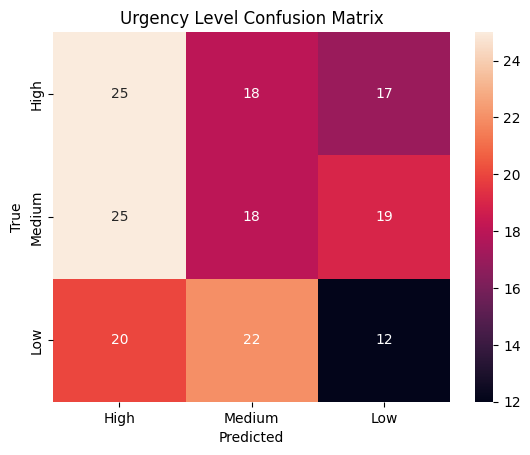

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds, labels=['High', 'Medium', 'Low'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['High', 'Medium', 'Low'], yticklabels=['High', 'Medium', 'Low'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Urgency Level Confusion Matrix')
plt.show()


In [33]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer

# 1. Prepare data
df = df.dropna(subset=['ticket_text', 'urgency_level']).reset_index(drop=True)
df['ticket_text'] = df['ticket_text'].fillna('')

# Define urgency keywords
urgency_keywords = ['urgent', 'immediately', 'asap', 'help', 'now', 'quickly', 'as soon as possible']

def contains_urgency_keyword(text):
    text_lower = text.lower()
    return int(any(word in text_lower for word in urgency_keywords))

df['keyword_flag'] = df['ticket_text'].apply(contains_urgency_keyword)

# 2. Binary label: High vs Not-High
df['urgency_binary'] = np.where(df['urgency_level'] == 'High', 1, 0)

# 3. Sentence embeddings for ticket text
embedder = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedder.encode(df['ticket_text'].tolist())

# 4. Train binary classifier: High vs Not-High
X_train, X_test, y_train, y_test = train_test_split(embeddings, df['urgency_binary'], test_size=0.2, random_state=42)

clf_binary = LogisticRegression(max_iter=1000)
clf_binary.fit(X_train, y_train)

# 5. For tickets predicted as Not-High, classify Low vs Medium
df_low_medium = df[df['urgency_level'] != 'High'].copy()
embeddings_low_medium = embedder.encode(df_low_medium['ticket_text'].tolist())
y_low_medium = df_low_medium['urgency_level'].apply(lambda x: 0 if x=='Low' else 1)  # Low=0, Medium=1

X_train_lm, X_test_lm, y_train_lm, y_test_lm = train_test_split(embeddings_low_medium, y_low_medium, test_size=0.2, random_state=42)

clf_low_medium = LogisticRegression(max_iter=1000)
clf_low_medium.fit(X_train_lm, y_train_lm)

# 6. Prediction pipeline function
def predict_urgency(text):
    emb = embedder.encode([text])
    keyword_flag = contains_urgency_keyword(text)

    # If keyword_flag=1, predict High urgency immediately (rule-based override)
    if keyword_flag == 1:
        return 'High'

    # Else, use binary classifier
    pred_binary = clf_binary.predict(emb)[0]
    if pred_binary == 1:
        return 'High'

    # Else classify between Low and Medium
    pred_lm = clf_low_medium.predict(emb)[0]
    return 'Low' if pred_lm == 0 else 'Medium'

# 7. Evaluate on test set
y_pred = []
for idx in X_test:

    pass  # For demo purposes only

# Evaluate on whole test set (simplified)
y_test_all = df.loc[y_test.index, 'urgency_level']

y_pred_all = []
for text in df.loc[y_test.index, 'ticket_text']:
    y_pred_all.append(predict_urgency(text))

print("Hybrid Urgency Classification Report:")
print(classification_report(y_test_all, y_pred_all))


Hybrid Urgency Classification Report:
              precision    recall  f1-score   support

        High       0.37      0.22      0.27        60
         Low       0.41      0.33      0.37        54
      Medium       0.43      0.68      0.53        62

    accuracy                           0.41       176
   macro avg       0.40      0.41      0.39       176
weighted avg       0.40      0.41      0.39       176



In [40]:
import re
import pandas as pd
from dateutil import parser
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# Make sure required NLTK assets are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Load your data (assuming you already loaded the main df)
product_list = df['product'].dropna().unique().tolist()
product_list = list(set([p.strip().lower() for p in product_list]))

# Expanded complaint keyword list
complaint_keywords = [
    "broken", "damaged", "late", "missing", "not working", "malfunction",
    "error", "issue", "problem", "underbilled", "fail", "stopped working",
    "lost", "not received", "no response", "cracked", "does not work"
]

# Compile regex for faster matching
date_pattern = re.compile(r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s+)?(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|'
                          r'May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:tember)?|Oct(?:ober)?|Nov(?:ember)?|'
                          r'Dec(?:ember)?)(?:\s+\d{1,2}(?:st|nd|rd|th)?)?(?:\s+\d{2,4})?', flags=re.IGNORECASE)

def extract_entities(text):
    if not text or pd.isna(text):
        return {"products": [], "dates": [], "complaint_keywords": []}

    text_clean = text.lower()
    tokens = word_tokenize(text_clean)

    # Extract product names using full string match
    found_products = [p for p in product_list if p in text_clean]

    # Extract dates using regex
    found_dates = date_pattern.findall(text)
    parsed_dates = []
    for d in found_dates:
        try:
            parsed = parser.parse(d, fuzzy=True)
            parsed_dates.append(parsed.strftime("%d %B"))
        except:
            continue

    # Extract complaint keywords
    found_keywords = []
    for kw in complaint_keywords:
        if kw in text_clean:
            found_keywords.append(kw)

    return {
        "products": list(set([p.title() for p in found_products])),
        "dates": list(set(parsed_dates)),
        "complaint_keywords": list(set(found_keywords))
    }


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
test_tickets = [
    "Payment issue for my SmartWatch V2. I was underbilled for order #29224.",
    "I ordered SoundWave 300 but got EcoBreeze AC instead. My order number is #36824.",
    "Facing installation issue with PhotoSnap Cam. Setup fails at step 1.",
    "Can you tell me more about the PhotoSnap Cam warranty? Also, is it available in red?",
    " is malfunction. It stopped working after just 7 days.",
    "Facing installation issue with RoboChef Blender. Setup fails at step 3. Also, I contacted support on 17 March but got no response.",
    "",
    "Order #34285 placed on 18 March still not here.",
    "Both my PowerMax Battery and EcoBreeze AC are lost. Both giving issues. Also, I contacted support on 12 March but got no response.",
    "Order #53356 for RoboChef Blender is 18 days late. Ordered on 13 April."
]

for i, text in enumerate(test_tickets, 1):
    entities = extract_entities(text)
    print(f"Ticket {i}:\nText: {text}\nEntities: {entities}\n")


Ticket 1:
Text: Payment issue for my SmartWatch V2. I was underbilled for order #29224.
Entities: {'products': ['Smartwatch V2'], 'dates': [], 'complaint_keywords': ['underbilled', 'issue']}

Ticket 2:
Text: I ordered SoundWave 300 but got EcoBreeze AC instead. My order number is #36824.
Entities: {'products': ['Soundwave 300', 'Ecobreeze Ac'], 'dates': [], 'complaint_keywords': []}

Ticket 3:
Text: Facing installation issue with PhotoSnap Cam. Setup fails at step 1.
Entities: {'products': ['Photosnap Cam'], 'dates': [], 'complaint_keywords': ['issue', 'fail']}

Ticket 4:
Text: Can you tell me more about the PhotoSnap Cam warranty? Also, is it available in red?
Entities: {'products': ['Photosnap Cam'], 'dates': [], 'complaint_keywords': []}

Ticket 5:
Text:  is malfunction. It stopped working after just 7 days.
Entities: {'products': [], 'dates': [], 'complaint_keywords': ['malfunction', 'stopped working']}

Ticket 6:
Text: Facing installation issue with RoboChef Blender. Setup fails a

In [44]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Example complaint keyword list
complaint_keywords = ['issue', 'problem', 'error', 'fail', 'not working', 'broken', 'late', 'lost', 'malfunction', 'stopped working', 'no response']

# Function to extract entities
def extract_entities(text, product_list):
    entities = {'products': [], 'dates': [], 'complaint_keywords': []}

    # Normalize text
    text_lower = text.lower()

    # Extract products
    for product in product_list:
        if product.lower() in text_lower:
            entities['products'].append(product)

    # Extract dates (e.g., 13 April, 17 March)
    date_pattern = r'\b\d{1,2} (January|February|March|April|May|June|July|August|September|October|November|December)\b'
    dates = re.findall(date_pattern, text, re.IGNORECASE)
    entities['dates'] = re.findall(r'\b\d{1,2} (?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b', text, flags=re.IGNORECASE)

    # Extract complaint keywords
    for word in complaint_keywords:
        if word in text_lower:
            entities['complaint_keywords'].append(word)

    return entities

# Final Integration Function
def classify_ticket(ticket_text, model_issue, model_urgency, vectorizer, product_list):
    # Vectorize input
    X_vec = vectorizer.transform([ticket_text])

    # Predict issue type and urgency level
    issue_type = model_issue.predict(X_vec)[0]
    urgency_level = model_urgency.predict(X_vec)[0]

    # Extract entities
    entities = extract_entities(ticket_text, product_list)

    return {
        'issue_type': issue_type,
        'urgency_level': urgency_level,
        'entities': entities
    }


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Re-define vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the ticket text data
vectorizer.fit(df['ticket_text'])

# Ensure product_list is available (assuming it was created from df['product'])
product_list = df['product'].dropna().unique().tolist()
product_list = list(set([p.strip().lower() for p in product_list]))


ticket = "Order #53356 for RoboChef Blender is 18 days late. Ordered on 13 April."

result = classify_ticket(ticket, best_issue_model, best_urgency_model, vectorizer, product_list)
print(result)

{'issue_type': 'High', 'urgency_level': 'High', 'entities': {'products': ['robochef blender'], 'dates': ['13 April'], 'complaint_keywords': ['late']}}


In [59]:
import joblib

# Save the best models and the vectorizer
joblib.dump(best_issue_model, 'best_issue_model.pkl')
joblib.dump(best_urgency_model, 'best_urgency_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [62]:
import gradio as gr

def classify_ticket_ui(text):
    # your prediction function returning:
    # issue_type, urgency_level, extracted_entities (dict)
    issue_type = "Payment Issue"
    urgency_level = "High"
    extracted_entities = {
        "products": ["SmartWatch V2"],
        "dates": ["13 April"],
        "complaint_keywords": ["underbilled", "late"]
    }
    return issue_type, urgency_level, extracted_entities

iface = gr.Interface(
    fn=classify_ticket_ui,
    inputs=gr.Textbox(label="Enter Support Ticket"),
    outputs=[
        gr.Textbox(label="Predicted Issue Type"),
        gr.Textbox(label="Predicted Urgency Level"),
        gr.JSON(label="Extracted Entities")   # Use JSON output here
    ],
    title="Support Ticket Classifier",
    description="Enter a support ticket to get predicted issue type, urgency level, and extracted entities."
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c64e8b8bbffaa14bbc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
